# Low rank tensor decomposition applied to Kirchhoff plate

This is an extension case to the problem in `01_tensordecomposition_analyticalfunc.ipynb`. The data is now procured from simulating a simple plate example using Kirchhoff plate theory.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [4]:
#%matplotlib qt

## Plate definition

For modelling the plate, a finite element method (FEM) code is provided.

In [5]:
import sys
sys.path.append('..') # source

from codes.PlateKirchhoff.element_matrices import build_element_stiffness, build_element_mass
from codes.PlateKirchhoff.fe_system import fe_data, assemble_load, assemble_system
from codes.PlateKirchhoff import fem_solver

In [6]:
# parameters

#coord = np.array([[0.,  0. ], [1.,  0. ], [1.,  0.7], [0.,  0.7]])
c_s = np.array([1., 0.7, 0.003])

# Structured nodal coordinates 
nElem_x = 20                                    # Number of elements in x direction
nElem_y = 20                                    # Number of elements in y direction
freq = np.linspace(10,400,91)

coord = np.zeros(((nElem_y+1)*(nElem_x+1),2)) # Two coords per node (x,y)
a_x = c_s[0] / nElem_x
a_y = c_s[1] / nElem_y
for m in range(nElem_x+1):
    for n in range(nElem_y+1):
        coord[m*(nElem_y+1)+n] = np.array([(m)*a_x, (n)*a_y])


# Generate element connectivity
connect = np.zeros((nElem_y*nElem_x,4), dtype=np.int32) # Four nodes per element (linear quadrilateral)
for m in range(nElem_x):
    for n in range(nElem_y):
        elem_connect = np.zeros(4, dtype=np.int32)
        elem_connect[0] = (m)*(nElem_y+1) + (n)
        elem_connect[1] = elem_connect[0] + (nElem_y+1)
        elem_connect[2] = elem_connect[1] + 1
        elem_connect[3] = elem_connect[0] + 1
        connect[m*nElem_y+n] = elem_connect

# Material properties
mat = np.array([7.0e+10, 3.4e-01, 2.7e+03])
material = np.zeros((nElem_x*nElem_y, 3))
material[:,:] = mat    # Emod, Poissons ratio, Density (Same material for all elements / homogeneous domain)

n_unkwn_elem_disp = connect.shape[0]*4

# arrange
my_fe_data = fe_data()
my_fe_data.coord = coord
my_fe_data.material = material
my_fe_data.pDim = c_s
my_fe_data.connect = connect
my_fe_data.bc = np.array([])

# Matrix assembly
KMAT, MMAT = assemble_system(my_fe_data)
DMAT = np.zeros_like(MMAT)

n = KMAT.shape[0]
fload = np.zeros((n,1))
fload[0,0] = 1

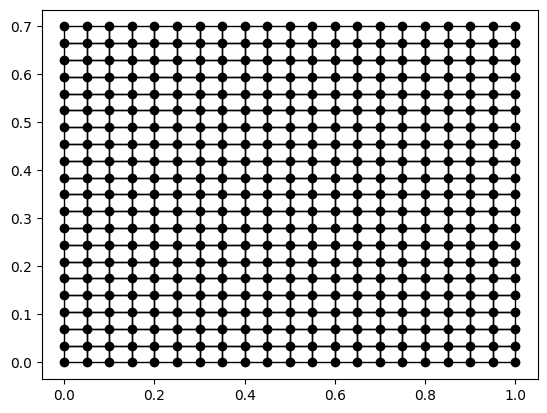

In [7]:
from matplotlib.patches import Rectangle

visualize = True
if visualize:
    # Plot the chosen mesh
    fig, ax = plt.subplots()
    ax.scatter(coord[:,0],coord[:,1],color="black")
    for element in connect: 
        ax.add_patch(Rectangle((min(coord[element[:],0]), min(coord[element[:],1])), a_x, a_y, fc='none', color="black"))
    plt.show()

Construct the two-dimensional plate domain:

In [8]:
x = np.linspace(0,c_s[0],nElem_x+1)
y = np.linspace(0,c_s[1],nElem_y+1)

X,Y,F = np.meshgrid(x,y,freq)

Solve the FEM system:

In [9]:

yFEM = fem_solver.solve_dense_system_response(KMAT, MMAT, DMAT, fload, freq)
# filter z translation
yFEM = np.real(yFEM[0::4, :])

In [10]:
#coordinates = np.vstack((X.ravel(), Y.ravel(), F.ravel())).T
yFEM_TensorList = []
n_node = len(yFEM)
for inode in range(n_node):
    yFEM_TensorList.append(yFEM[inode,:].flatten())

stacked_vectors = np.array(yFEM_TensorList[0])
for vector in yFEM_TensorList[1:]:
    stacked_vectors = np.concatenate((stacked_vectors, np.array(vector)))

yFEM_Tensor = stacked_vectors.reshape(X.shape)

### Export simulation data

Run the data loading cell to skip the above simulation with already computed data.

In [11]:
data_filename = f'../data/data_kirchhoffplate{nElem_x}x{nElem_y}.npy'

In [12]:
np.save(data_filename,yFEM_Tensor)

In [13]:
yFEM_Tensor = np.load(data_filename)

## Visualize FEM results

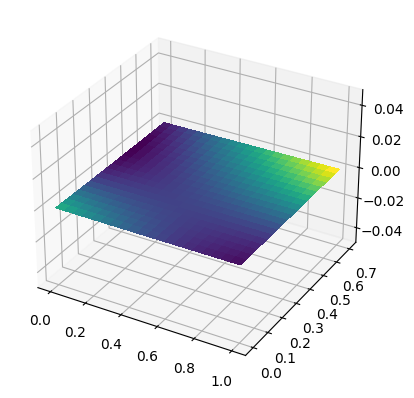

In [14]:
visualize = True

if visualize:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = [ax.plot_surface(X[:,:,0], Y[:,:,0], yFEM_Tensor[:,:,0], antialiased=False, cmap='viridis')]
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-6, 6)
    ax.set_zlim(min(stacked_vectors), max(stacked_vectors))
    def update_plot(frame, surf, func):
        ax.collections.clear()  # Clear the previous plot
        surf[0] = ax.plot_surface(X[:,:,frame], Y[:,:,frame], func[:,:,frame], antialiased=False, cmap='viridis')  # Plot new surface
        ax.set_title(f'freq {round(freq[frame],2)} Hz')
        return surf

    ani = animation.FuncAnimation(fig, update_plot, frames=len(freq), fargs=(surf, yFEM_Tensor), interval=100)
    plt.show()

## Perform low-rank tensor approximation

In [15]:
from tensorly.decomposition import parafac
import tensorly as tl

Performs CP decomposition:

In [16]:
r = np.ones((3,), dtype=int)*50
factors_tl = parafac(yFEM_Tensor, rank=r[0])
yFEM_Tensor_reconstructed = tl.cp_to_tensor(factors_tl)

print(f'Reconstruction error: {tl.norm(yFEM_Tensor-yFEM_Tensor_reconstructed)}')

Reconstruction error: 0.0002879278253231574


Performs tensor train decomposition:

In [17]:
from tensorly.decomposition import tucker

r = [15,15,40]
factors_tl = tucker(yFEM_Tensor, rank=r)
yFEM_Tensor_reconstructed = tl.tucker_to_tensor(factors_tl)

print(f'Reconstruction error: {tl.norm(yFEM_Tensor-yFEM_Tensor_reconstructed)}')

Reconstruction error: 2.261990882901954e-05


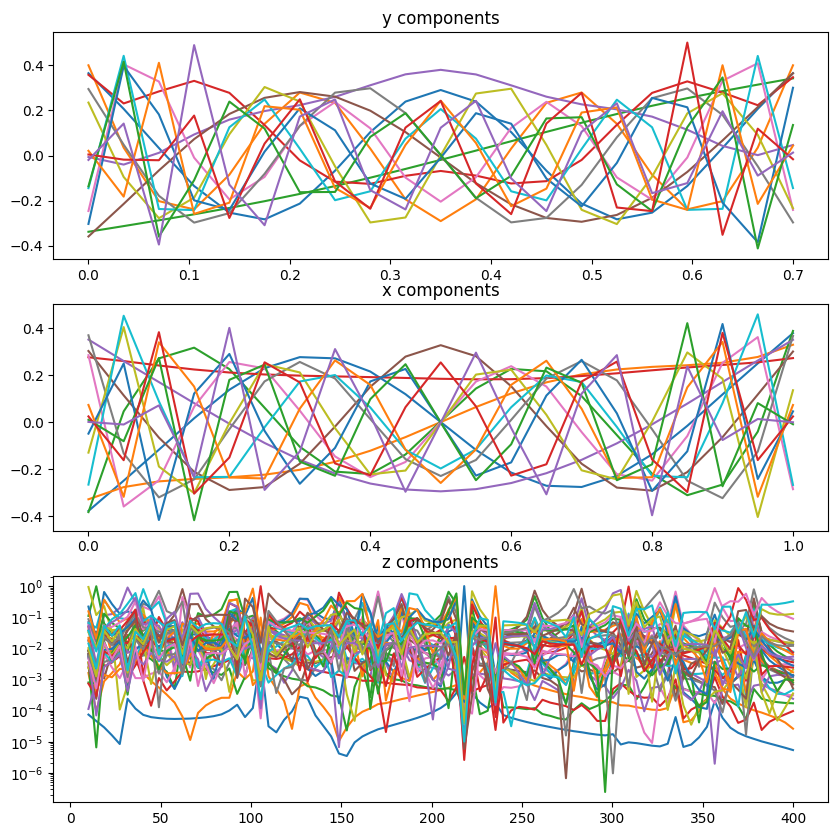

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(y,factors_tl[1][0][:,:r[0]])
plt.title('y components')
plt.subplot(312)
plt.plot(x,factors_tl[1][1][:,:r[1]])
plt.title('x components')
plt.subplot(313)
plt.semilogy(freq,np.abs(factors_tl[1][2][:,:r[2]]))
plt.title('z components')
plt.show()

## Visualization

/home/sreekumar/.local/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


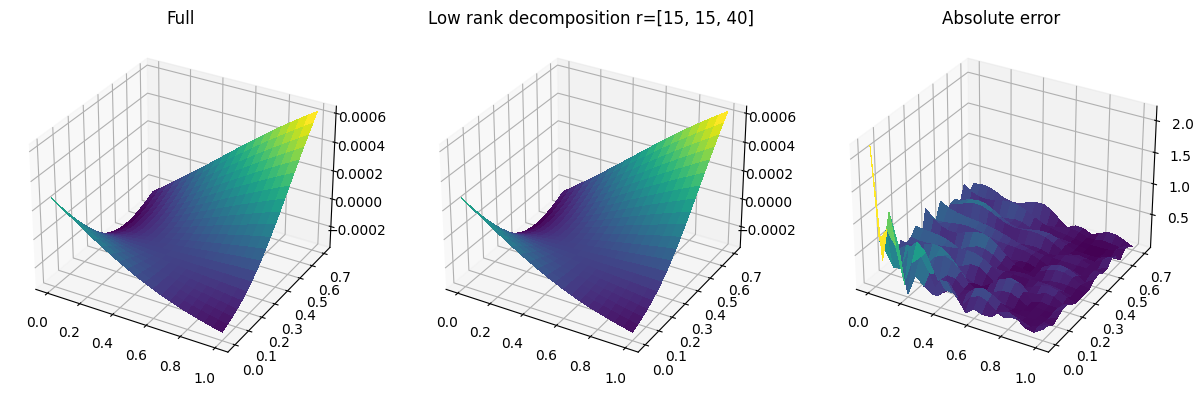

In [19]:
visualize = True
A = yFEM_Tensor
A_reconstructed = yFEM_Tensor_reconstructed

cmap = 'viridis'

if visualize:
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = [ax1.plot_surface(X[:,:,0], Y[:,:,0], A[:,:,0], antialiased=False, cmap=cmap)]
    # ax1.set_xlim(-5, 5)
    # ax1.set_ylim(-6, 6)
    # ax1.set_zlim(-1, 1)
    ax.set_zlim(min(stacked_vectors), max(stacked_vectors))
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = [ax2.plot_surface(X[:,:,0], Y[:,:,0], A_reconstructed[:,:,0], antialiased=False, cmap=cmap)]
    # ax2.set_xlim(-5, 5)
    # ax2.set_ylim(-6, 6)
    # ax2.set_zlim(-1, 1)
    ax.set_zlim(min(stacked_vectors), max(stacked_vectors))
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = [ax3.plot_surface(X[:,:,0], Y[:,:,0], np.abs(A_reconstructed[:,:,0]-A[:,:,0]), antialiased=False, cmap=cmap)]
    # ax3.set_xlim(-5, 5)
    # ax3.set_ylim(-6, 6)
    # ax3.set_zlim(-1, 1)
    ax.set_zlim(min(stacked_vectors), max(stacked_vectors))

    ax1.set_title('Full')
    ax2.set_title(f'Low rank decomposition r={r}')
    ax3.set_title('Absolute error')
    def update_plot(frame, surf1, surf2, surf3, func1, func2):
        ax1.collections.clear()  # Clear the previous plot
        ax2.collections.clear()  # Clear the previous plot
        ax3.collections.clear()  # Clear the previous plot
        surf1[0] = ax1.plot_surface(X[:,:,frame], Y[:,:,frame], func1[:,:,frame], antialiased=False, cmap=cmap)  # Plot new surface
        surf2[0] = ax2.plot_surface(X[:,:,frame], Y[:,:,frame], func2[:,:,frame], antialiased=False, cmap=cmap)  # Plot new surface
        surf3[0] = ax3.plot_surface(X[:,:,frame], Y[:,:,frame], np.abs(func2[:,:,frame]-func1[:,:,frame]), antialiased=False, cmap=cmap)  # Plot new surface

        plt.suptitle(f'freq {round(freq[frame],2)} Hz')
        return surf1, surf2, surf3

    ani = animation.FuncAnimation(fig, update_plot, frames=len(freq), fargs=(surf1, surf2, surf3, A, A_reconstructed), interval=400)
    plt.show()

Plotting error over frequency:

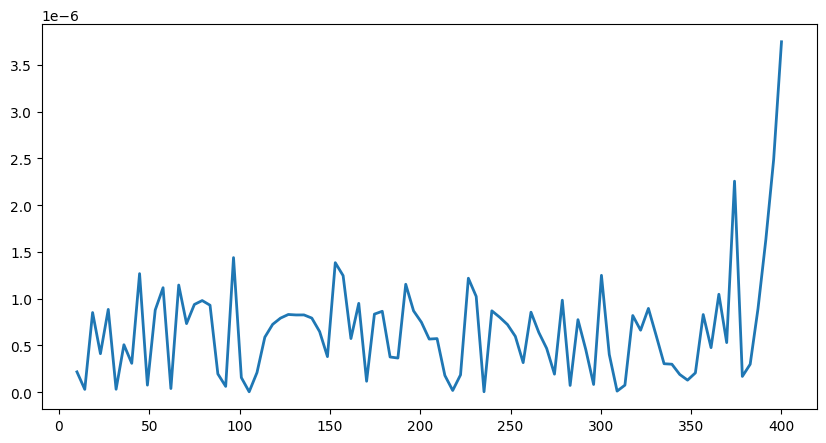

In [20]:
abs_error =np.abs(yFEM_Tensor-yFEM_Tensor_reconstructed)
abs_error_freq = []
for ifreq in range(len(freq)):
    abs_error_freq.append(max(abs_error[:,:,ifreq].flatten()))

plt.figure(figsize=(10,5))
plt.plot(freq, abs_error_freq, linewidth=2)
plt.show()

Plot the snapshot comparison at the frequency point with maximum error:

Text(0.5, 0.98, 'freq 400 Hz')

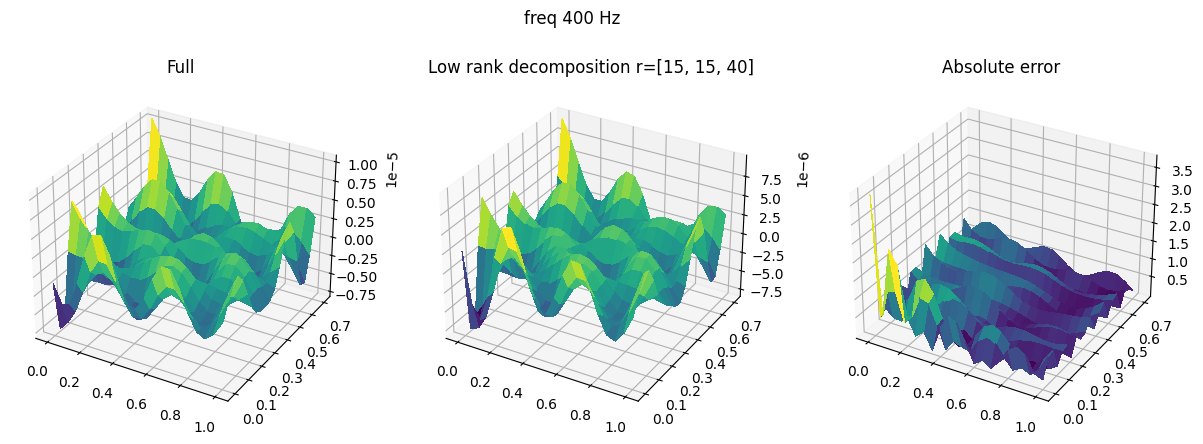

In [21]:
max_error_freq_frame = np.argmax(abs_error_freq)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
surf1 = [ax1.plot_surface(X[:,:,0], Y[:,:,0], A[:,:,max_error_freq_frame], antialiased=False, cmap=cmap)]
# ax1.set_xlim(-5, 5)
# ax1.set_ylim(-6, 6)
# ax1.set_zlim(-1, 1)
ax2 = fig.add_subplot(132, projection='3d')
surf2 = [ax2.plot_surface(X[:,:,0], Y[:,:,0], A_reconstructed[:,:,max_error_freq_frame], antialiased=False, cmap=cmap)]
# ax2.set_xlim(-5, 5)
# ax2.set_ylim(-6, 6)
# ax2.set_zlim(-1, 1)
ax3 = fig.add_subplot(133, projection='3d')
surf3 = [ax3.plot_surface(X[:,:,0], Y[:,:,0], abs_error[:,:,max_error_freq_frame], antialiased=False, cmap=cmap)]
# ax3.set_xlim(-5, 5)
# ax3.set_ylim(-6, 6)
# ax3.set_zlim(-1, 1)

ax1.set_title('Full')
ax2.set_title(f'Low rank decomposition r={r}')
ax3.set_title('Absolute error')
plt.suptitle(f'freq {round(freq[max_error_freq_frame])} Hz')